In [2]:
pip install --upgrade fosforml

     |████████████████████████████████| 51kB 5.1MB/s eta 0:00:011
     |████████████████████████████████| 1.9MB 8.4MB/s eta 0:00:01
     |████████████████████████████████| 10.9MB 40.7MB/s eta 0:00:01
     |████████████████████████████████| 38.6MB 62.8MB/s eta 0:00:01
     |████████████████████████████████| 200.3MB 126kB/s s eta 0:00:01                         | 25.7MB 68.6MB/s eta 0:00:03
     |████████████████████████████████| 133kB 103.1MB/s eta 0:00:01
     |████████████████████████████████| 81kB 27.0MB/s eta 0:00:01
     |████████████████████████████████| 1.3MB 65.6MB/s eta 0:00:01
     |████████████████████████████████| 61kB 24.4MB/s eta 0:00:01
     |████████████████████████████████| 98.7MB 308kB/s  eta 0:00:01
     |████████████████████████████████| 51kB 19.5MB/s eta 0:00:01
     |████████████████████████████████| 174kB 102.0MB/s eta 0:00:01
     |████████████████████████████████| 39.9MB 63.6MB/s eta 0:00:01
     |████████████████████████████████| 2.5MB 62.0MB/s eta 0:00:01
    

In [35]:
pip install seaborn

     |████████████████████████████████| 296kB 6.5MB/s eta 0:00:01
You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import fosforml
from fosforml.model_manager.snowflakesession import get_session
my_session = get_session()

In [4]:
my_session.connection.database

'ASSORTMENT_PLANNING'

In [5]:
my_session.connection.schema

'CPG_BRONZE'

In [6]:
table_name = "ASSORTMENT_PLANNING.CPG_BRONZE.SALES_CLEAN"

In [7]:
sf_df = my_session.sql("select * from {}".format(table_name))

In [8]:
type(sf_df)

snowflake.snowpark.dataframe.DataFrame

In [9]:
df=sf_df.to_pandas()

In [10]:
type(df)

pandas.core.frame.DataFrame

In [16]:
df=df.sort_values(by='TRANS_DATE')

In [20]:
df.head(5)

,MNTH_CODE,TRANS_DATE,START_DATE,SALES_VALUE,SALES_UNITS,SALES_VOLUME,SALES_PTR_VALUE,OC_CODE,DISTRIBUTOR_CODE,OUTLET_CODE,CITY,STATE,COUNTY,STREET,PRODUCT_CODE,CATEGORY,SUBCATEGORY,BRAND
804225,202309,2023-08-29,2023-08-28,518.18,3,0.001125,518.181818,202209,DB0209,OL32665,Florence,Arizona,City Center,Str1,PRD0059,Perfume and Deodrants,Male Deodrant,Sapphire
765439,202309,2023-08-29,2023-08-28,140.00,16,0.000448,142.857143,202209,DB0209,OL49699,Phoenix,Arizona,Dolphin,Str1,PRD0094,Perfume and Deodrants,Unisex Perfume,Mocha
765438,202309,2023-08-29,2023-08-28,137.14,16,0.000272,142.857143,202209,DB0209,OL48766,Ashland,Kentucky,Dolphin,Str2,PRD0028,Soap,Toilet Soap,Indigo
765437,202309,2023-08-29,2023-08-28,159.09,1,0.000240,159.090909,202209,DB0706,OL160684,Plano,Texas,City Center,Str2,PRD0125,Lotion,Head Lotion,Burgundy
316878,202309,2023-08-29,2023-08-28,52.50,12,0.000132,53.571429,202209,DB0655,OL175633,Puyallup,Washington,Santa Cruz,Str5,PRD0105,Perfume and Deodrants,Female Perfume,Garnet


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 966400 entries, 804225 to 360638
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   MNTH_CODE         966400 non-null  int32  
 1   TRANS_DATE        966400 non-null  object 
 2   START_DATE        966400 non-null  object 
 3   SALES_VALUE       966400 non-null  float64
 4   SALES_UNITS       966400 non-null  int16  
 5   SALES_VOLUME      966400 non-null  float64
 6   SALES_PTR_VALUE   966400 non-null  float64
 7   OC_CODE           966400 non-null  int32  
 8   DISTRIBUTOR_CODE  966400 non-null  object 
 9   OUTLET_CODE       966400 non-null  object 
 10  CITY              966400 non-null  object 
 11  STATE             966400 non-null  object 
 12  COUNTY            966400 non-null  object 
 13  STREET            966400 non-null  object 
 14  PRODUCT_CODE      966400 non-null  object 
 15  CATEGORY          966400 non-null  object 
 16  SUBCATEGORY       96

In [23]:
#Converting into datetime format

df['TRANS_DATE'] = pd.to_datetime(df['TRANS_DATE'])
df['START_DATE'] = pd.to_datetime(df['START_DATE'])

In [25]:
df.shape

(966400, 18)

Clustering the Objects

In [57]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming your DataFrame is named df
# Convert TRANS_DATE and START_DATE to datetime format
df['TRANS_DATE'] = pd.to_datetime(df['TRANS_DATE'])
df['START_DATE'] = pd.to_datetime(df['START_DATE'])

# Aggregate sales units by category
sales_units_by_category = df.pivot_table(index='OUTLET_CODE', columns='CATEGORY', values='SALES_UNITS', aggfunc='sum', fill_value=0).reset_index()

# Aggregate other features
other_features = df.groupby('OUTLET_CODE').agg({
    'TRANS_DATE': ['count', 'nunique']
}).reset_index()

other_features.columns = ['OUTLET_CODE', 'Num_Transactions', 'Unique_Transaction_Days']

# Merge the features
store_features = pd.merge(sales_units_by_category, other_features, on='OUTLET_CODE')

# Normalize the features
scaler = StandardScaler()
store_features_scaled = scaler.fit_transform(store_features.drop('OUTLET_CODE', axis=1))

In [58]:
store_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18833 entries, 0 to 18832
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   OUTLET_CODE              18833 non-null  object
 1   Dental                   18833 non-null  int64 
 2   Hair Care                18833 non-null  int64 
 3   Kids Care                18833 non-null  int64 
 4   Lotion                   18833 non-null  int64 
 5   Perfume and Deodrants    18833 non-null  int64 
 6   Soap                     18833 non-null  int64 
 7   Wipes                    18833 non-null  int64 
 8   Num_Transactions         18833 non-null  int64 
 9   Unique_Transaction_Days  18833 non-null  int64 
dtypes: int64(9), object(1)
memory usage: 1.4+ MB


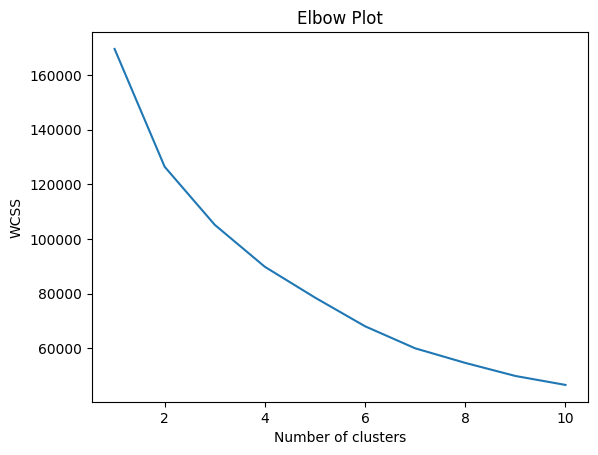

In [59]:
# Determine the optimal number of clusters using the elbow plot
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(store_features_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('Elbow Plot')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [ ]:
# # Save the final dataset to a CSV file
# store_features.to_csv('outlet_code_cluster_mapping.csv', index=False)

In [63]:
# Based on the elbow plot, choose the optimal number of clusters 
optimal_clusters = 3
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
store_features['Cluster'] = kmeans.fit_predict(store_features_scaled)

In [64]:
# Display the clustered DataFrame
store_features.head()

,OUTLET_CODE,Dental,Hair Care,Kids Care,Lotion,Perfume and Deodrants,Soap,Wipes,Num_Transactions,Unique_Transaction_Days,Cluster
0,OL10328,6,63,17,9,64,62,0,34,10,0
1,OL10329,43,762,51,60,182,50,0,195,37,0
2,OL10330,138,852,316,577,589,652,0,573,32,1
3,OL10331,6,13,18,23,7,20,0,49,16,0
4,OL10332,512,848,650,0,704,1490,0,147,20,1


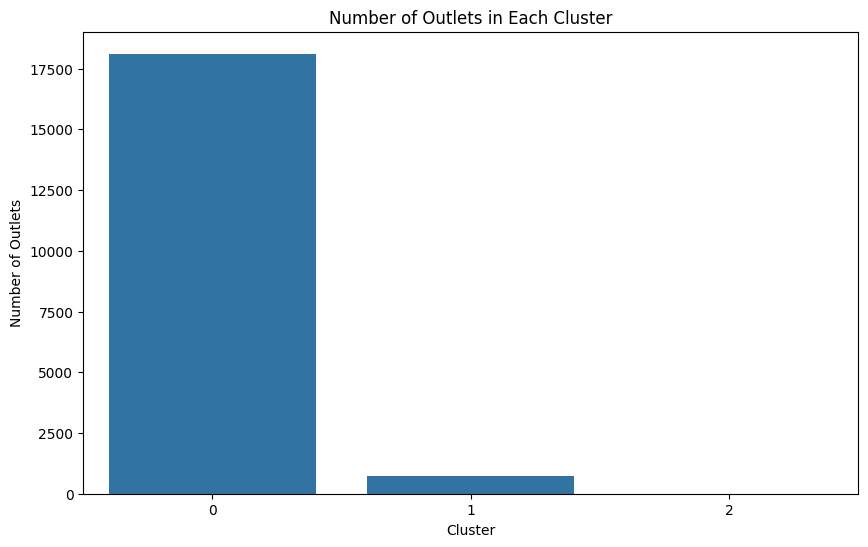

In [65]:
# Plot the number of outlets in each cluster
outlet_counts = store_features['Cluster'].value_counts().reset_index()
outlet_counts.columns = ['Cluster', 'Number_of_Outlets']

plt.figure(figsize=(10, 6))
sns.barplot(x='Cluster', y='Number_of_Outlets', data=outlet_counts)
plt.title('Number of Outlets in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Outlets')
plt.show()

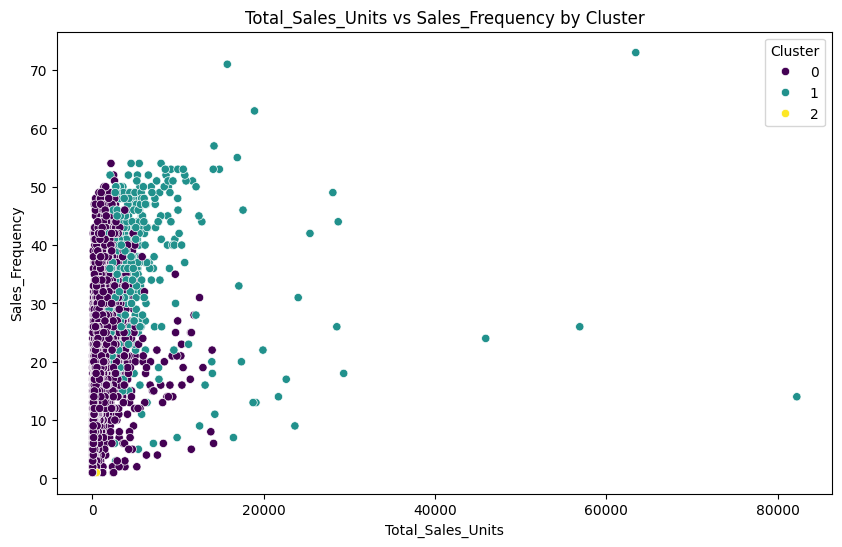

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter Plot: Sales Value vs Sales Volume colored by cluster
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Total_Sales_Units', y='Sales_Frequency', hue='Cluster', data=store_features, palette='viridis')
plt.title('Total_Sales_Units vs Sales_Frequency by Cluster')
plt.xlabel('Total_Sales_Units')
plt.ylabel('Sales_Frequency')
plt.legend(title='Cluster')
plt.show()

In [39]:
import pandas as pd

# Assuming your DataFrame is named store_features and it contains the 'Cluster' column
# Count the number of outlets in each cluster
outlet_counts = store_features['Cluster'].value_counts().reset_index()
outlet_counts.columns = ['Cluster', 'Number_of_Outlets']

# Display the number of outlets in each cluster
print(outlet_counts)

   Cluster  Number_of_Outlets
0        0              18424
1        1                408
2        2                  1
